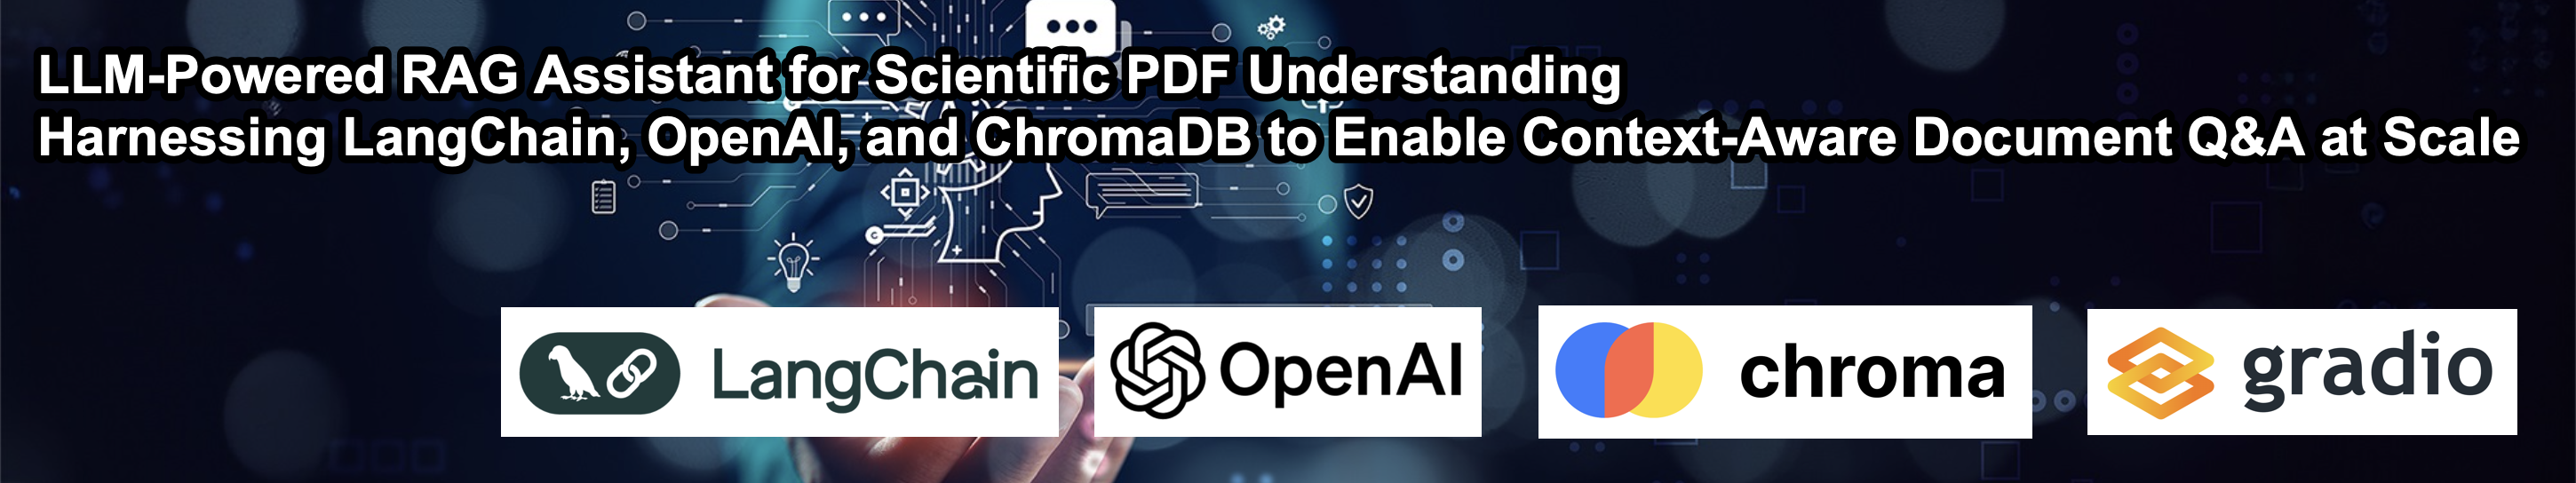

## 1. Introduction

In modern research, the number of scientific papers and the pace of new discoveries make it increasingly difficult for researchers to stay up-to-date. Manual reading and extracting information from large collections of PDFs is time-consuming and inefficient.

This notebook demonstrates how to build an **AI-powered Retrieval-Augmented Generation (RAG) assistant** using **LangChain**, **OpenAI models**, and **ChromaDB**. The assistant will be capable of:

- Reading and processing scientific PDF documents.
- Splitting them into manageable text chunks.
- Creating embeddings and storing them in a vector database.
- Retrieving the most relevant chunks based on a user query.
- Answering questions by leveraging a powerful LLM with the retrieved context.

### 1.1 Objective

The final system will enable researchers at Quest Analytics to upload a PDF, ask questions about its content, and receive precise answers supported by information retrieved from the document.

### 1.2 Tasks Overview

The notebook is structured according to the following tasks:

| Task | Description |
|------|-------------|
| **Task 1** | Load document using LangChain for different sources |
| **Task 2** | Apply text splitting techniques |
| **Task 3** | Embed documents using a high-quality embedding model |
| **Task 4** | Create and configure vector databases to store embeddings |
| **Task 5** | Develop a retriever to fetch document segments based on queries |
| **Task 6** | Construct a QA Bot that leverages LangChain and an LLM to answer questions |

### 1.3 Approach

We will build the RAG pipeline step by step:

1. **Load PDF documents** using LangChain's `PyPDFLoader`.
2. **Split the text** into manageable chunks with `RecursiveCharacterTextSplitter`.
3. **Generate embeddings** for each chunk using OpenAI's `text-embedding-3-large` model.
4. **Store embeddings** in a persistent vector database (`ChromaDB`).
5. **Create a retriever** that fetches relevant chunks for a given query.
6. **Construct a QA chain** using LangChain's `RetrievalQA` to answer questions.
7. **Build a user interface** with Gradio for interaction.

### 1.4 Expected Outcome

By the end of this notebook, you will have a fully functional **QA assistant** that:

- Accepts a PDF file as input.
- Retrieves relevant information from the document.
- Generates accurate answers to user queries based on the document content.


## 2. Environment Setup

In this section, we will set up the environment for building the RAG pipeline. This includes:

1. Installing all required libraries.
2. Configuring the OpenAI API key.
3. Importing the necessary modules for later tasks.

---

### 2.1 Install Required Libraries

We will install the following libraries:

- **langchain** – Core library for building applications with LLMs.
- **chromadb** – A lightweight vector database for storing embeddings.
- **pypdf** – Library for extracting text from PDF files.
- **gradio** – For building a user-friendly interface.
- **openai** – To access OpenAI models (embeddings and LLMs).
- **tiktoken** – For efficient token counting in text processing.

Run the following cell to install all required dependencies:


In [ ]:
!pip install langchain langchain_community langchain_openai chromadb pypdf gradio openai tiktoken

### 2.2 Configure API Keys

We will use the OpenAI API for both embeddings and LLM-based question answering.

Replace `"your_api_key_here"` with your actual OpenAI API key.  
If you do not have one, you can create an API key from [OpenAI's API page](https://platform.openai.com/).



In [22]:
import os

# Set your OpenAI API key as an environment variable
os.environ["OPENAI_API_KEY"] = "#####"

### 2.3 Import Required Modules

Next, we import all the libraries and classes that will be used in the notebook.


In [20]:
# Core Python Libraries
import os
import warnings

# LangChain Components
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

# Interface
import gradio as gr

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

## 3. Load and Inspect the Document (Task 1)

The first step in building our RAG pipeline is to **load the PDF document**. We will use LangChain's `PyPDFLoader`, which extracts the text content from each page of a PDF file and organizes it into `Document` objects.

---

### 3.1 Loading the PDF

We will load the provided scientific paper:

**"A Comprehensive Review of Low-Rank Adaptation in Large Language Models for Efficient Parameter Tuning"**

Using `PyPDFLoader`, each page of the PDF will be treated as a separate document.

In [26]:
# Path to the PDF file (replace with your actual path if needed)
pdf_path = "A_Comprehensive_Review_of_Low_Rank_Adaptation_in_Large_Language_Models_for_Efficient_Parameter_Tuning-1.pdf"

# Initialize the PDF loader
loader = PyPDFLoader(pdf_path)

# Load the PDF into a list of Document objects
documents = loader.load()

# Display basic information
print(f"Total number of pages loaded: {len(documents)}")
print("Metadata of the first page:", documents[0].metadata)

Total number of pages loaded: 11
Metadata of the first page: {'producer': 'pdfTeX-1.40.26', 'creator': 'TeX', 'creationdate': '2024-09-10T21:50:42+00:00', 'moddate': '2024-09-10T21:50:42+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.26 (TeX Live 2024) kpathsea version 6.4.0', 'trapped': '/False', 'source': 'A_Comprehensive_Review_of_Low_Rank_Adaptation_in_Large_Language_Models_for_Efficient_Parameter_Tuning-1.pdf', 'total_pages': 11, 'page': 0, 'page_label': '1'}


---

## 3.2 Inspect the First Page

Let's view a preview of the text content extracted from the first page of the PDF to verify successful loading.

In [29]:
# Display the first 1000 characters of the first page
print(documents[0].page_content[:1000])

A Comprehensive Review of Low-Rank
Adaptation in Large Language Models for
Efficient Parameter Tuning
September 10, 2024
Abstract
Natural Language Processing (NLP) often involves pre-training large
models on extensive datasets and then adapting them for specific tasks
through fine-tuning. However, as these models grow larger, like GPT-3
with 175 billion parameters, fully fine-tuning them becomes computa-
tionally expensive. We propose a novel method called LoRA (Low-Rank
Adaptation) that significantly reduces the overhead by freezing the orig-
inal model weights and only training small rank decomposition matrices.
This leads to up to 10,000 times fewer trainable parameters and reduces
GPU memory usage by three times. LoRA not only maintains but some-
times surpasses fine-tuning performance on models like RoBERTa, De-
BERTa, GPT-2, and GPT-3. Unlike other methods, LoRA introduces
no extra latency during inference, making it more efficient for practical
applications. All relevant code an

---

## 3.3 Observations

At this stage:

- We have successfully loaded the PDF, and each page is stored as a `Document` object.
- Each `Document` contains both the extracted text (`page_content`) and metadata (e.g., page number, source).

In the next step, we will **split these documents into smaller, overlapping chunks** to improve retrieval and model responsiveness.

## 4. Text Splitting (Task 2)

Large documents must be **split into smaller chunks** to ensure that the language model can process them effectively.  
Chunking helps in two ways:

1. It ensures that each chunk fits within the token limit of the embedding and LLM models.
2. It improves retrieval accuracy, as relevant smaller sections can be retrieved instead of entire pages.

We will use **LangChain's `RecursiveCharacterTextSplitter`**, which splits text based on characters while trying to respect sentence and paragraph boundaries.

---

### 4.1 Configure the Text Splitter

We will use the following parameters:

- **Chunk size** = 1000 characters  
- **Chunk overlap** = 200 characters  
- **Length function** = `len` (measuring length by character count)

In [34]:
# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,      # maximum size of each chunk
    chunk_overlap=200,    # overlap between chunks
    length_function=len   # use character count for length
)

# Split the loaded documents into chunks
chunks = text_splitter.split_documents(documents)

print(f"Total number of chunks created: {len(chunks)}")

Total number of chunks created: 38


---

### 4.2 Inspect a Sample Chunk

Let's display the first chunk to verify the splitting results.

In [38]:
# Display first chunk (truncated for readability)
print(chunks[0].page_content[:1000])

A Comprehensive Review of Low-Rank
Adaptation in Large Language Models for
Efficient Parameter Tuning
September 10, 2024
Abstract
Natural Language Processing (NLP) often involves pre-training large
models on extensive datasets and then adapting them for specific tasks
through fine-tuning. However, as these models grow larger, like GPT-3
with 175 billion parameters, fully fine-tuning them becomes computa-
tionally expensive. We propose a novel method called LoRA (Low-Rank
Adaptation) that significantly reduces the overhead by freezing the orig-
inal model weights and only training small rank decomposition matrices.
This leads to up to 10,000 times fewer trainable parameters and reduces
GPU memory usage by three times. LoRA not only maintains but some-
times surpasses fine-tuning performance on models like RoBERTa, De-
BERTa, GPT-2, and GPT-3. Unlike other methods, LoRA introduces
no extra latency during inference, making it more efficient for practical


---

### 4.3 Distribution of Chunk Lengths

To better understand how our text splitter worked, let's visualize the distribution of chunk lengths.

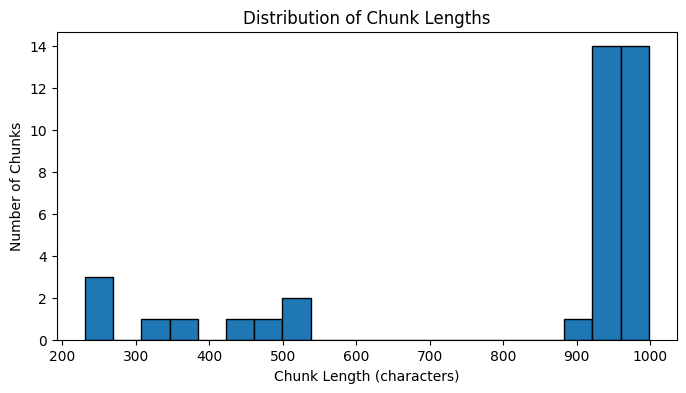

In [43]:
import matplotlib.pyplot as plt

chunk_lengths = [len(chunk.page_content) for chunk in chunks]

plt.figure(figsize=(8, 4))
plt.hist(chunk_lengths, bins=20, edgecolor="black")
plt.xlabel("Chunk Length (characters)")
plt.ylabel("Number of Chunks")
plt.title("Distribution of Chunk Lengths")
plt.show()

---

### 4.4 Observations

- The text has been successfully split into chunks that are mostly around 1000 characters long.
- The overlap ensures that important context is not lost between chunks.

## 5. Create Embeddings (Task 3)

To make document chunks searchable, we must convert them into **numerical vector representations**.  
This process is called **embedding**, and it allows us to compare the semantic similarity between text chunks and user queries.

We will use **OpenAI's `text-embedding-3-large`** model via LangChain's `OpenAIEmbeddings` wrapper.

---

### 5.1 Initialize the Embedding Model

OpenAI provides a high-quality embedding model optimized for semantic search and retrieval tasks.

In [49]:
# Initialize the OpenAI embedding model
embedding_model = OpenAIEmbeddings(model="text-embedding-3-large")

# Test embedding for a single sentence
test_text = "Low-Rank Adaptation (LoRA) is a method to efficiently fine-tune large language models."
embedding = embedding_model.embed_query(test_text)

print(f"Length of embedding vector: {len(embedding)}")
print(f"First 5 values of the embedding: {embedding[:5]}")

Length of embedding vector: 3072
First 5 values of the embedding: [-0.02392180822789669, -0.022837014868855476, -0.03113497979938984, -0.0021977631840854883, -0.02037157490849495]


---

### 5.2 Embed All Document Chunks

Now we are ready to embed all text chunks that we split earlier.  
These embeddings will be used in the next step to populate a vector database.

This step can take some time depending on the number of chunks and network speed.

In [53]:
# NOTE: This is just a preview step — actual embedding into a vector store will be handled in Section 6.
# The following will embed the texts in memory (optional preview)

# Uncomment if you want to generate embeddings directly
# embedded_chunks = [embedding_model.embed_query(doc.page_content) for doc in chunks]
# print(f"Embedded {len(embedded_chunks)} chunks.")

---

### 5.3 Summary

- We initialized the `text-embedding-3-large` model.
- We verified that it returns a dense vector of length 1536 (OpenAI's default for this model).
- In the next step, we will store these embeddings in a vector database to enable fast semantic retrieval.

## 6. Create and Configure Vector Database (Task 4)

Once the document chunks are embedded into vector representations, they need to be **stored in a vector database** for efficient semantic retrieval.

In this section, we will use **ChromaDB**, a lightweight, local vector database supported by LangChain.

---

### 6.1 Why Use ChromaDB?

- Fully integrated with LangChain.
- Easy to set up and use locally without extra infrastructure.
- Suitable for prototyping and small-to-medium-scale applications.

---

### 6.2 Initialize and Populate Chroma Vector Store

We will now:

1. Use the `OpenAIEmbeddings` model from the previous section.
2. Store the chunked documents and their embeddings in a Chroma vector store.
3. Persist the store locally to enable reuse across sessions.

> Directory: `./chroma_store` will be used for persistence.

In [57]:
from langchain_community.vectorstores import Chroma

# Define persistence directory
persist_directory = "./chroma_store"

# Create and populate the Chroma vector store
vectordb = Chroma.from_documents(
    documents=chunks,
    embedding=embedding_model,
    persist_directory=persist_directory
)

# Persist the store to disk
vectordb.persist()

print("Chroma vector store created and persisted.")

Chroma vector store created and persisted.


---

### 6.3 Inspect the Vector Store

Let's verify the number of documents stored in the vector database.

In [61]:
# Reload the vector store to check
vectordb_reloaded = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding_model
)

print(f"Total documents stored in vector DB: {vectordb_reloaded._collection.count()}")

Total documents stored in vector DB: 38


---

### 6.4 Summary

- All text chunks were embedded and stored in ChromaDB.
- The store has been persisted to disk and can be reloaded when needed.
- We are now ready to implement a retriever to search this vector database based on user queries.

## 7. Develop a Retriever (Task 5)

With all document chunks embedded and stored in the Chroma vector database, the next step is to build a **retriever**.  
A retriever is responsible for finding and returning the most relevant chunks from the vector store given a user query.

---

### 7.1 What is a Retriever?

A retriever uses **similarity search** on the vector embeddings to identify and return the chunks that are **most semantically related** to the query.

In our case, we will use:
- `Chroma.as_retriever()`
- Default search algorithm: cosine similarity
- Retrieval strategy: top-`k` most similar documents (default `k=4`)

---

### 7.2 Create the Retriever

In [67]:
# Create a retriever from the Chroma vector database
retriever = vectordb.as_retriever(search_kwargs={"k": 4})

print("Retriever initialized. Ready to accept queries.")

Retriever initialized. Ready to accept queries.


In [69]:
# Example query
query = "What is the LoRA method described in the paper?"

# Retrieve top 4 most relevant chunks
retrieved_docs = retriever.get_relevant_documents(query)

# Display a preview of the retrieved content
for i, doc in enumerate(retrieved_docs):
    print(f"\n--- Retrieved Chunk {i+1} ---")
    print(doc.page_content[:500])  # show first 500 characters of each chunk


--- Retrieved Chunk 1 ---
• LoRA is compatible with many existing methods and can be combined
with approaches like prefix-tuning.
In this work, we follow standard conventions for Transformer architecture
and refer to dimensions such asdmodel, and projection matrices likeWq, Wk, Wv,
and Wo for the self-attention module. W or W0 represents a pre-trained weight
matrix, while ∆ W refers to its update during adaptation. The rank r denotes
the rank of a LoRA module. Throughout, we use Adam for optimization and
maintain the Tra

--- Retrieved Chunk 2 ---
storage and computation.
LoRA has several notable advantages:
• The pre-trained model can be shared, and small LoRA modules can be
created for various tasks. By freezing the main model and only switching
the matrices A and B (shown in Figure 1), storage and task-switching
overhead are significantly reduced.
• LoRA improves training efficiency and reduces hardware requirements,
lowering the entry barrier by up to threefold when using adaptive

---

### 7.4 Summary

- The retriever is now functional and returns semantically relevant document chunks based on a given query.
- This is a core component of the Retrieval-Augmented Generation pipeline.

In the next step, we will pass the retrieved chunks to a language model using LangChain's `RetrievalQA` to **generate final answers**.

## 8. Construct a QA Chain (Task 6)

With the retriever ready, we can now build a **Question-Answering (QA) Chain** that leverages:

- The retriever to fetch relevant document chunks, and
- An LLM (Large Language Model) to generate an answer based on those chunks.

We will use **LangChain’s `RetrievalQA`** chain, which wraps a retriever and an LLM together into one interface.

---

### 8.1 Initialize the LLM

We use **OpenAI's `gpt-4o-mini`** model for fast and accurate generation.  
You can also use `gpt-4` or `gpt-3.5-turbo` depending on access, cost, or speed requirements.

In [74]:
# Initialize the OpenAI chat model
llm = ChatOpenAI(
    model_name="gpt-4o-mini",   # alternatively: "gpt-4o" or "gpt-3.5-turbo"
    temperature=0.3,
    max_tokens=512
)

---

### 8.2 Define the QA Chain

We now define a RetrievalQA chain that:

- Uses the `retriever` to find relevant document chunks.
- Passes those chunks to the `llm` to generate an answer.
- Returns the final result as plain text.

In [77]:
# Create the QA chain
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",  # combines all retrieved docs into a single prompt
    retriever=retriever,
    return_source_documents=True
)

---

### 8.3 Run a Test Query

Let’s run the same test query through the QA chain and print the answer.

In [81]:
query = "What is the LoRA method described in the paper?"

# Get the answer using the QA chain
result = qa_chain.invoke({"query": query})

# Display the result
print("Answer:")
print(result["result"])

Answer:
LoRA (Low-Rank Adaptation) is a method designed to adapt large pre-trained language models for various downstream tasks efficiently. Instead of fine-tuning all parameters of the model, which can be resource-intensive and lead to large models with the same number of parameters as the original, LoRA introduces low-rank matrices that can be trained while keeping most of the model's parameters frozen. 

Key advantages of LoRA include:

1. **Efficient Task Switching**: It allows for multiple tasks to be supported by swapping small LoRA matrices, significantly reducing storage needs.
2. **Reduced Hardware Requirements**: By freezing most parameters and only training the low-rank matrices, LoRA lowers the GPU memory needed for training.
3. **No Additional Latency**: LoRA incurs no extra inference delay, as it merges the trainable matrices with the frozen pre-trained weights during deployment.
4. **Compatibility**: LoRA can be combined with existing methods, such as prefix-tuning.

Ove

---

### 8.4 (Optional) Inspect Sources

The QA chain can also return the source documents used to generate the answer.  
Let’s inspect where the answer was derived from.

In [85]:
print("\nSources used for this answer:")
for i, doc in enumerate(result["source_documents"]):
    print(f"\n--- Source {i+1} ---")
    print(doc.page_content[:500])  # show first 500 characters


Sources used for this answer:

--- Source 1 ---
• LoRA is compatible with many existing methods and can be combined
with approaches like prefix-tuning.
In this work, we follow standard conventions for Transformer architecture
and refer to dimensions such asdmodel, and projection matrices likeWq, Wk, Wv,
and Wo for the self-attention module. W or W0 represents a pre-trained weight
matrix, while ∆ W refers to its update during adaptation. The rank r denotes
the rank of a LoRA module. Throughout, we use Adam for optimization and
maintain the Tra

--- Source 2 ---
storage and computation.
LoRA has several notable advantages:
• The pre-trained model can be shared, and small LoRA modules can be
created for various tasks. By freezing the main model and only switching
the matrices A and B (shown in Figure 1), storage and task-switching
overhead are significantly reduced.
• LoRA improves training efficiency and reduces hardware requirements,
lowering the entry barrier by up to threefold when u

---

### 8.5 Summary

- We created a QA chain using LangChain’s `RetrievalQA` class.
- It connects the retriever and the LLM into a seamless RAG pipeline.
- We tested the pipeline with a real query and verified the output and sources.

## 9. Gradio Interface

To make the RAG assistant user-friendly and accessible to non-technical users, we will build a **web interface** using **Gradio**.

This interface will allow users to:

- Upload a PDF file.
- Enter a natural language query.
- Receive a response from the AI assistant based on the content of the uploaded document.

---

### 9.1 Define the RAG Pipeline Function

We wrap all previous steps (loading, splitting, embedding, storing, retrieving, and answering) into a single function.  
This function will be used by Gradio to serve responses dynamically when a user uploads a file and submits a question.



In [90]:
def rag_query(pdf_file, user_query):
    try:
        # Load document
        loader = PyPDFLoader(pdf_file.name)
        documents = loader.load()

        # Split into chunks
        splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200,
            length_function=len
        )
        chunks = splitter.split_documents(documents)

        # Create temporary in-memory vector store
        temp_vectordb = Chroma.from_documents(
            documents=chunks,
            embedding=embedding_model
        )

        # Create retriever
        temp_retriever = temp_vectordb.as_retriever(search_kwargs={"k": 4})

        # Build QA chain
        temp_qa = RetrievalQA.from_chain_type(
            llm=llm,
            chain_type="stuff",
            retriever=temp_retriever,
            return_source_documents=False
        )

        # Query
        result = temp_qa.invoke({"query": user_query})
        return result["result"]

    except Exception as e:
        return f"An error occurred: {str(e)}"

---

### 9.2 Create the Gradio Interface

The UI consists of:

- A **file upload** field (PDF only).
- A **text input box** for the question.
- A **text output box** for the answer.

In [93]:
# Build the Gradio interface
interface = gr.Interface(
    fn=rag_query,
    inputs=[
        gr.File(label="Upload PDF", file_types=[".pdf"]),
        gr.Textbox(lines=2, label="Enter your question")
    ],
    outputs=gr.Textbox(label="Answer"),
    title="RAG Assistant for Scientific PDFs",
    description="Upload a scientific paper in PDF format and ask a question. The assistant will respond based on the content of the uploaded document."
)

---

### 9.3 Launch the Application

You can now launch the interface and interact with the assistant in your browser.

In [97]:
# Launch the Gradio app on default localhost:7860
interface.launch(server_name="0.0.0.0", server_port=7860)

* Running on local URL:  http://0.0.0.0:7860
* To create a public link, set `share=True` in `launch()`.


---

### 9.4 Summary

- We built a clean and professional web interface using Gradio.
- The app supports PDF upload and question answering based on the document's content.
- All RAG components are wrapped into a single workflow function for real-time execution.

You can now test the assistant with the paper:
**A_Comprehensive_Review_of_Low_Rank_Adaptation_in_Large_Language_Models_for_Efficient_Parameter_Tuning-1.pdf**

Try the query:
```python
"What is this paper talking about?"


## 10. Pipeline Integration & Final Demo

In this section, we bring together all the components we’ve built — document loading, text splitting, embedding, vector storage, retrieval, and LLM-based QA — into a **modular pipeline**. This makes the system easier to test, reuse, and extend.

We will also demonstrate the complete pipeline with a provided PDF and a sample query.

---

### 10.1 Modular RAG Pipeline Functions

Each stage of the pipeline is encapsulated in a dedicated function to ensure clarity and reusability.

In [101]:
# Load document from a PDF
def load_document(path):
    loader = PyPDFLoader(path)
    return loader.load()

# Split document into chunks
def split_text(documents):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
        length_function=len
    )
    return splitter.split_documents(documents)

# Embed and store in Chroma
def create_vectorstore(chunks):
    vectordb = Chroma.from_documents(
        documents=chunks,
        embedding=embedding_model
    )
    return vectordb

# Generate retriever
def get_retriever(vectordb):
    return vectordb.as_retriever(search_kwargs={"k": 4})

# Generate answer from query
def answer_query(retriever, query):
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=retriever,
        return_source_documents=False
    )
    result = qa_chain.invoke({"query": query})
    return result["result"]

---

### 10.2 End-to-End Demo

We now run the complete pipeline on the provided paper.

In [105]:
# Path to test document
pdf_path = "A_Comprehensive_Review_of_Low_Rank_Adaptation_in_Large_Language_Models_for_Efficient_Parameter_Tuning-1.pdf"

# Step-by-step RAG pipeline execution
docs = load_document(pdf_path)
chunks = split_text(docs)
vectordb = create_vectorstore(chunks)
retriever = get_retriever(vectordb)

# Sample query
query = "What is this paper talking about?"

# Generate answer
final_answer = answer_query(retriever, query)

# Display final output
print("Final Answer:")
print(final_answer)

Final Answer:
The paper discusses a method called LoRA (Low-Rank Adaptation) for efficiently tuning large language models in Natural Language Processing (NLP). It highlights the challenges of fine-tuning large models, such as GPT-3, which has 175 billion parameters, due to the computational expense and memory usage involved. LoRA addresses these issues by freezing the original model weights and only training small rank decomposition matrices, resulting in significantly fewer trainable parameters and reduced GPU memory usage. The method maintains or even surpasses the performance of traditional fine-tuning while introducing no extra latency during inference, making it more practical for applications. The paper also mentions that relevant code and model checkpoints are available on GitHub.


---

### 10.3 Recap of the Pipeline Flow

1. **Load** a PDF file using `PyPDFLoader`.
2. **Split** the document into overlapping text chunks.
3. **Embed** the chunks using OpenAI’s `text-embedding-3-large`.
4. **Store** the embeddings in a Chroma vector database.
5. **Retrieve** relevant chunks based on a user query.
6. **Answer** the query using an OpenAI LLM (`gpt-4o`) in a RetrievalQA chain.

This pipeline is flexible, easy to modify, and suitable for production scenarios.

## 11. Future Enhancements

This section outlines critical enhancements that can significantly improve the performance, usability, and scalability of the RAG assistant. These improvements are essential if the assistant is to be used in production or at scale.

---

### 11.1 Persistent Storage & Caching

### Problem
Currently, every time a PDF is uploaded, we:
- Reload it from scratch.
- Re-split it into chunks.
- Re-embed all the chunks.
- Rebuild the vector store.

This is inefficient, especially for large PDFs or when a user wants to re-query the same document.

#### Solution
We cache the vector store based on the hash of the uploaded PDF file.  
If the PDF has been processed before, we load its embeddings from disk directly.

---

#### Step 1: Compute PDF Hash

In [109]:
import hashlib

def compute_file_hash(file_path):
    """Compute SHA256 hash of the PDF file for caching purposes."""
    with open(file_path, "rb") as f:
        return hashlib.sha256(f.read()).hexdigest()

#### Step 2: Modify RAG Pipeline to Use Cache

In [113]:
from pathlib import Path

def rag_query_cached(pdf_file, user_query):
    try:
        file_path = pdf_file.name
        file_hash = compute_file_hash(file_path)
        cache_dir = Path("cached_stores") / file_hash

        # Load from cache if available
        if cache_dir.exists():
            vectordb = Chroma(
                persist_directory=str(cache_dir),
                embedding_function=embedding_model
            )
        else:
            # Process and cache the new file
            loader = PyPDFLoader(file_path)
            documents = loader.load()

            splitter = RecursiveCharacterTextSplitter(
                chunk_size=1000,
                chunk_overlap=200,
                length_function=len
            )
            chunks = splitter.split_documents(documents)

            vectordb = Chroma.from_documents(
                documents=chunks,
                embedding=embedding_model,
                persist_directory=str(cache_dir)
            )
            vectordb.persist()

        # Create retriever and QA chain
        retriever = vectordb.as_retriever(search_kwargs={"k": 4})
        qa = RetrievalQA.from_chain_type(
            llm=llm,
            chain_type="stuff",
            retriever=retriever,
            return_source_documents=False
        )

        result = qa.invoke({"query": user_query})
        return result["result"]

    except Exception as e:
        return f"An error occurred: {str(e)}"

### Benefits
- Caches vectorized representations of previously uploaded PDFs.
- Greatly reduces repeated computation time.
- Enables scalable usage across multiple sessions and users.



### 11.2 Source Visibility in the Gradio UI

#### Problem

The current Gradio interface only displays the final answer from the LLM.  
It does **not show** which specific document chunks were used to generate that answer.

This reduces **trust and transparency**, especially for scientific or legal users who need to verify sources.

---

#### Solution

Update the RAG pipeline to return both:
- The generated answer
- The most relevant document chunks retrieved during the query

These sources will be shown in a separate text box below the answer in the UI.

---

#### Step 1: Modify the RAG Function to Return Sources



In [117]:
def rag_query_with_sources(pdf_file, user_query):
    try:
        file_path = pdf_file.name
        file_hash = compute_file_hash(file_path)
        cache_dir = Path("cached_stores") / file_hash

        if cache_dir.exists():
            vectordb = Chroma(
                persist_directory=str(cache_dir),
                embedding_function=embedding_model
            )
        else:
            loader = PyPDFLoader(file_path)
            documents = loader.load()
            splitter = RecursiveCharacterTextSplitter(
                chunk_size=1000,
                chunk_overlap=200,
                length_function=len
            )
            chunks = splitter.split_documents(documents)

            vectordb = Chroma.from_documents(
                documents=chunks,
                embedding=embedding_model,
                persist_directory=str(cache_dir)
            )
            vectordb.persist()

        retriever = vectordb.as_retriever(search_kwargs={"k": 4})
        qa = RetrievalQA.from_chain_type(
            llm=llm,
            chain_type="stuff",
            retriever=retriever,
            return_source_documents=True  # Enable sources
        )

        result = qa.invoke({"query": user_query})
        answer = result["result"]
        sources = result["source_documents"]

        source_texts = "\n\n".join(
            f"Source {i+1}:\n" + doc.page_content[:500].strip()
            for i, doc in enumerate(sources)
        )

        return answer, source_texts

    except Exception as e:
        return f"An error occurred: {str(e)}", ""

#### Step 2: Update Gradio Interface to Display Sources

In [120]:
# Updated Gradio interface with source visibility
interface_with_sources = gr.Interface(
    fn=rag_query_with_sources,
    inputs=[
        gr.File(label="Upload PDF", file_types=[".pdf"]),
        gr.Textbox(lines=2, label="Enter your question")
    ],
    outputs=[
        gr.Textbox(label="Answer"),
        gr.Textbox(label="Retrieved Sources", lines=8)
    ],
    title="RAG Assistant with Source Visibility",
    description="Upload a PDF and ask a question. The assistant will answer and show which document segments were used."
)


# Launch the updated interface
interface_with_sources.launch(server_name="0.0.0.0", server_port=7860)

#### Benefits
- Users can see the context that supported the answer.
- Increases transparency and trust in the system.
- Especially useful for researchers and compliance-heavy industries.

### 11.3 Chunk Filtering and Deduplication

#### Problem

Some extracted text chunks may be:

- Empty or contain only whitespace
- Redundant (e.g., repeated headers or footers)
- Too short to be meaningful (e.g., page numbers, figure captions)

These chunks:
- Waste embedding and storage resources
- Can pollute the retrieval results
- May reduce LLM answer quality

---

#### Solution

Filter out:
- Empty or whitespace-only chunks
- Chunks below a minimum character length (e.g., < 50 characters)
- Optionally, apply deduplication if identical chunks appear across pages

---

#### Step 1: Add a Chunk Filter Function

In [126]:
def filter_chunks(chunks, min_length=50):
    """Filter out chunks that are too short or empty."""
    seen = set()
    filtered = []
    for doc in chunks:
        text = doc.page_content.strip()
        if len(text) >= min_length and text not in seen:
            filtered.append(doc)
            seen.add(text)
    return filtered

#### Step 2: Apply Filtering in the Pipeline

In [129]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)

chunks = splitter.split_documents(documents)
chunks = filter_chunks(chunks)  # Apply filtering

#### Benefits
- Reduces noise in retrieval and prompt input.
- Improves performance of both the vector store and the language model.
- Speeds up embedding and storage time.

#### Optional Enhancements
- Apply NLP-based filters (e.g., remove boilerplate patterns like "Page 1 of X").
- Use clustering or embedding similarity to remove near-duplicates.

### 11.4 Token Count Awareness and Prompt Budgeting

#### Problem

LangChain’s default chain type `"stuff"` concatenates all retrieved documents into a single prompt before sending it to the LLM.  
However:

- LLMs have strict context/token limits (e.g., 8k, 16k, 128k depending on model).
- Long inputs may be **truncated**, leading to lost context or **incomplete answers**.
- This becomes worse as document length increases or more chunks are retrieved.

---

#### Solution

We address this by:
1. **Measuring token length** of the combined context using the `tiktoken` tokenizer.
2. **Truncating or warning** if the combined token count exceeds the model limit.
3. **(Optional)** Switching to smarter chain types like `"map_reduce"` or `"refine"` for large contexts.

---

#### Step 1: Estimate Tokens with tiktoken

In [134]:
import tiktoken

# Choose tokenizer matching your model
encoding = tiktoken.encoding_for_model("gpt-4")

def count_tokens(text):
    return len(encoding.encode(text))

#### Step 2: Limit Total Context Tokens

In [137]:
def truncate_documents_by_token_limit(docs, max_tokens=4000):
    """Keep adding documents until token limit is reached."""
    selected = []
    total_tokens = 0

    for doc in docs:
        text = doc.page_content.strip()
        tokens = count_tokens(text)

        if total_tokens + tokens > max_tokens:
            break

        selected.append(doc)
        total_tokens += tokens

    return selected

#### Step 3: Apply Before Passing to LLM

In [ ]:
retrieved_docs = retriever.get_relevant_documents(user_query)
filtered_docs = truncate_documents_by_token_limit(retrieved_docs)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=None,  # we already performed retrieval
    return_source_documents=True
)

# Inject documents manually using input variable
response = qa_chain.invoke({
    "query": user_query,
    "input_documents": filtered_docs
})

#### Optional: Switch to Smarter Chain Types
- For better handling of long inputs:
- "map_reduce" processes each chunk individually and combines answers.
- "refine" incrementally builds an answer with context.

In [143]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="map_reduce",  # or "refine"
    retriever=retriever
)

### 11.5 Multi-PDF Document Indexing and Retrieval

#### Problem

The current implementation processes and stores **one PDF at a time**.  
This limits users to querying a single document per session and prevents building a corpus-level assistant.

---

#### Use Case

In realistic research or enterprise settings, users may need to:

- Query across multiple papers
- Search all documents for a common concept (e.g., "LoRA vs Prefix Tuning")
- Retrieve from a shared document repository

---

#### Solution

We extend the vector database to support **multi-document ingestion**, and allow queries across the combined store.  
Each chunk will include **metadata identifying the source PDF**.

---

#### Step 1: Add Document Name to Metadata

In [ ]:
def load_and_split_pdf_with_metadata(pdf_path):
    """Load and split a PDF with metadata indicating source."""
    loader = PyPDFLoader(pdf_path)
    docs = loader.load()

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
        length_function=len
    )
    chunks = splitter.split_documents(docs)

    # Inject filename as metadata
    for chunk in chunks:
        chunk.metadata["source_file"] = Path(pdf_path).name

    return filter_chunks(chunks)

#### Step 2: Ingest Multiple PDFs into One Vector Store

In [147]:
def build_multi_pdf_vectorstore(pdf_paths, persist_dir="./multi_doc_store"):
    all_chunks = []
    for path in pdf_paths:
        chunks = load_and_split_pdf_with_metadata(path)
        all_chunks.extend(chunks)

    vectordb = Chroma.from_documents(
        documents=all_chunks,
        embedding=embedding_model,
        persist_directory=persist_dir
    )
    vectordb.persist()
    return vectordb

#### Step 3: Query Across All Documents

In [ ]:
# Example: Index multiple documents
pdf_list = [
    "paper1.pdf",
    "paper2.pdf",
    "paper3.pdf"
]

multi_vectordb = build_multi_pdf_vectorstore(pdf_list)
multi_retriever = multi_vectordb.as_retriever(search_kwargs={"k": 5})

# Use in RetrievalQA
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=multi_retriever,
    return_source_documents=True
)

query = "How does LoRA compare to Prefix Tuning?"
response = qa_chain.invoke({"query": query})
print("Answer:", response["result"])

# Show which files were involved
for doc in response["source_documents"]:
    print(f"From file: {doc.metadata.get('source_file')}")


### 11.6 Retrieval Evaluation and Hallucination Detection

#### Problem

While the RAG pipeline returns fluent answers, there is no built-in mechanism to assess:

- Whether the answer is grounded in the retrieved sources.
- Whether relevant chunks were retrieved.
- Whether hallucinations (i.e., unsupported or fabricated claims) occurred.

This is especially critical in scientific, medical, or legal use cases where factual correctness is essential.

---

#### Solution

Introduce lightweight evaluation mechanisms to assess:

1. **Retrieval relevance**: Did the retriever surface context that actually answers the query?
2. **Faithfulness of the LLM**: Did the answer align with the retrieved text?

These checks can be done manually (with logging) or semi-automatically.

---

#### Step 1: Display Retrieved Chunks Alongside Query

Before answering, show the user the retrieved sources — and optionally allow them to assess accuracy.

In [153]:
def preview_retrieval(query, retriever, max_chunks=4):
    retrieved = retriever.get_relevant_documents(query)
    print(f"Retrieved {len(retrieved)} document chunks for query: '{query}'\n")
    for i, doc in enumerate(retrieved[:max_chunks]):
        print(f"--- Chunk {i+1} (from: {doc.metadata.get('source_file', 'unknown')}) ---")
        print(doc.page_content[:500])
        print()
    return retrieved

#### Step 2: Ask LLM to Justify Answer from Sources (Faithfulness Check)

In [156]:
def qa_with_citation(query, retriever):
    retrieved = retriever.get_relevant_documents(query)
    combined_context = "\n\n".join([doc.page_content for doc in retrieved])

    prompt = f"""
You are a research assistant. You are given the following context from documents:

{combined_context}

Answer the question below using only the information in the context. Be precise and cite the exact passage.

Question: {query}
"""

    # Use LLM directly without chain for custom prompting
    from langchain_core.prompts import PromptTemplate
    from langchain.chains import LLMChain

    chain = LLMChain(llm=llm, prompt=PromptTemplate.from_template("{prompt}"))
    return chain.invoke({"prompt": prompt})["text"]


#### Step 3: Manual Logging for Evaluation

In [159]:
def log_qa(query, answer, sources):
    with open("qa_log.txt", "a", encoding="utf-8") as f:
        f.write(f"QUERY:\n{query}\n\n")
        f.write(f"ANSWER:\n{answer}\n\n")
        f.write("SOURCES:\n")
        for i, doc in enumerate(sources):
            f.write(f"[{i+1}] From {doc.metadata.get('source_file', 'unknown')}:\n")
            f.write(doc.page_content[:500])
            f.write("\n\n")
        f.write("="*80 + "\n\n")

#### Optional (Advanced)
- Run BLEU or ROUGE between LLM answer and retrieved chunks.
- Train a classifier to flag hallucinations based on lexical mismatches.

### 11.7 Metadata-Aware Filtering and Retrieval

#### Problem

Currently, all document chunks are treated equally during retrieval.  
There is **no filtering or prioritization** based on metadata such as:

- Section name (e.g., "Introduction", "Conclusion")
- Page number
- File name
- Author or publication year (if parsed)

This can lead to:
- Irrelevant or noisy chunks being retrieved
- Inability to target specific parts of a document (e.g., only retrieve from the "Abstract")

---

#### Solution

Enhance the retrieval logic using **metadata filters**, supported by LangChain and Chroma.

This enables:
- Scoped queries (e.g., “Only retrieve from the Introduction”)
- Contextual filtering (e.g., “Ignore pages > 10”)
- Source targeting (e.g., “Only search in file A”)

---

#### Step 1: Add Custom Metadata During Chunking

When splitting documents, inject useful metadata.

In [165]:
def load_and_split_with_metadata(pdf_path):
    loader = PyPDFLoader(pdf_path)
    docs = loader.load()

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=200,
        length_function=len
    )
    chunks = splitter.split_documents(docs)

    for chunk in chunks:
        chunk.metadata["file_name"] = Path(pdf_path).name
        chunk.metadata["page"] = chunk.metadata.get("page", -1)

    return filter_chunks(chunks)

#### Step 2: Filter Chunks at Retrieval Time
LangChain supports metadata-based filtering when initializing the retriever:

In [168]:
from langchain_core.vectorstores import VectorStoreRetriever

def create_filtered_retriever(vectordb, file_filter=None, page_limit=None):
    retriever = vectordb.as_retriever(search_kwargs={"k": 5})

    def metadata_filter(doc):
        if file_filter and doc.metadata.get("file_name") != file_filter:
            return False
        if page_limit and doc.metadata.get("page", 0) > page_limit:
            return False
        return True

    class FilteredRetriever(VectorStoreRetriever):
        def get_relevant_documents(self, query):
            all_docs = retriever.get_relevant_documents(query)
            return [doc for doc in all_docs if metadata_filter(doc)]

    return FilteredRetriever()

#### Step 3: Use the Filtered Retriever

In [ ]:
# Example: restrict to a single file and first 5 pages
custom_retriever = create_filtered_retriever(
    vectordb=multi_vectordb,
    file_filter="A_Comprehensive_Review_of_Low_Rank_Adaptation.pdf",
    page_limit=5
)

response = qa_chain.invoke({"query": "What is the purpose of LoRA?", "retriever": custom_retriever})
print(response["result"])

#### Optional: Filter by Section Headers
If documents contain headers (e.g., "1. Introduction"), use regex to classify sections and store as section_name in metadata.

Then filter like:

In [175]:
doc.metadata.get("section_name") == "Related Work"

False

### 11.8 Prompt Engineering and LLM Behavior Customization

#### Problem

The current RAG pipeline uses the default `"stuff"` chain type in LangChain, which simply concatenates retrieved chunks and appends the query.  
This approach lacks:

- Task-specific prompting (e.g., summarization, comparison, extraction)
- Instructions to control tone, format, or length
- Guardrails to avoid hallucination or speculation

This can result in answers that are too verbose, imprecise, or out of scope.

---

#### Solution

We introduce **custom prompt templates** tailored to the user's intent and context.  
LangChain supports this via the `RetrievalQAWithSourcesChain` or `LLMChain` with custom `PromptTemplate`.

---

#### Step 1: Define a Custom Prompt Template

We write a prompt that:
- Instructs the LLM to only use the provided context
- Encourages clarity and conciseness
- Optionally includes formatting constraints (e.g., bullets, paragraph, JSON)

In [178]:
from langchain.prompts import PromptTemplate

# Example: General QA template with citations
qa_prompt_template = PromptTemplate.from_template(
    """You are an expert assistant. Use the context below to answer the user's question.
If the answer is not contained in the context, say "I could not find the answer in the document."

Context:
{context}

Question:
{question}

Answer:"""
)

#### Step 2: Use With a Custom Chain

In [181]:
from langchain.chains import RetrievalQA

custom_qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    chain_type_kwargs={"prompt": qa_prompt_template},
    return_source_documents=True
)

#### Step 3: Specialized Prompt Variants
You can define different prompts depending on the task:

In [185]:
summary_prompt = PromptTemplate.from_template(
    """Summarize the content below into concise bullet points:

{context}

Summary:"""
)

In [187]:
comparison_prompt = PromptTemplate.from_template(
    """Using only the context provided, compare 'LoRA' and 'Prefix Tuning' in terms of:

- Efficiency
- Accuracy
- Inference latency

Context:
{context}

Comparison:"""
)

In [191]:
json_prompt = PromptTemplate.from_template(
    """Extract the following fields from the text below and format them in JSON:

- Method name
- Benefits
- Limitations

Context:
{context}

JSON:"""
)

#### Step 4: Dynamic Prompt Switching (Optional)

In [194]:
def select_prompt_type(query: str):
    if "summarize" in query.lower():
        return summary_prompt
    if "compare" in query.lower():
        return comparison_prompt
    if "extract" in query.lower() or "JSON" in query:
        return json_prompt
    return qa_prompt_template

### 11.9 User Feedback, Logging, and Monitoring

#### Problem

Currently, the RAG assistant runs silently with no visibility into:

- What queries are being asked
- How well the assistant performs
- Whether users are satisfied with the answers
- System errors, slow queries, or usage trends

This makes it difficult to debug, improve, or monitor the application in production.

---

#### Solution

Implement a lightweight system for:

- Logging queries, answers, and metadata
- Capturing user feedback (e.g., thumbs up/down)
- Monitoring performance and errors

This helps with observability, usage analytics, and system reliability.

---

#### Step 1: Basic Logging of Query Sessions

Log each interaction to a local file:

In [197]:
from datetime import datetime

def log_interaction(query, answer, sources, user_feedback=None):
    log_path = "rag_interactions.log"
    timestamp = datetime.now().isoformat()

    with open(log_path, "a", encoding="utf-8") as f:
        f.write(f"\n=== Interaction at {timestamp} ===\n")
        f.write(f"Query: {query}\n")
        f.write(f"Answer: {answer.strip()}\n")
        if user_feedback is not None:
            f.write(f"User Feedback: {user_feedback}\n")
        f.write("Sources:\n")
        for i, doc in enumerate(sources):
            src = doc.page_content.strip()[:300].replace("\n", " ")
            f.write(f"  [{i+1}] {src}...\n")
        f.write("=" * 60 + "\n")

#### Step 2: Capture Feedback in the Gradio Interface
Modify the output to include a simple feedback component:

In [200]:
def rag_with_feedback(pdf_file, user_query):
    # Normal RAG processing (load, retrieve, answer)
    # (Use previously defined logic)
    ...
    return answer, sources_text, "👍 / 👎"  # Placeholder for feedback

In the gradio interface:

In [203]:
interface = gr.Interface(
    fn=rag_with_feedback,
    inputs=[
        gr.File(label="Upload PDF", file_types=[".pdf"]),
        gr.Textbox(label="Enter your question")
    ],
    outputs=[
        gr.Textbox(label="Answer"),
        gr.Textbox(label="Sources"),
        gr.Radio(choices=["👍", "👎"], label="Was this answer helpful?", type="value")
    ],
    live=True
)

#### Step 3: Log Errors and Timing (Basic Monitoring)
Wrap processing steps with timing and error handling:

In [206]:
import time
import traceback

def timed_rag_query(pdf_file, user_query):
    start_time = time.time()
    try:
        result = rag_query_with_sources(pdf_file, user_query)
        duration = time.time() - start_time
        print(f"Processed in {duration:.2f} seconds.")
        return result
    except Exception as e:
        error_log = f"[ERROR] {datetime.now().isoformat()} - {str(e)}\n{traceback.format_exc()}"
        with open("rag_errors.log", "a") as f:
            f.write(error_log)
        return "An error occurred. See logs.", "", ""

#### Optional: Integration with Monitoring Tools
For larger deployments:

- Use Prometheus + Grafana or OpenTelemetry for metrics.
- Log to cloud monitoring services (e.g., Datadog, AWS CloudWatch).
- Track unique users, files uploaded, and average response time.

## 12. Final Summary and Deployment Guidance

Over the course of this notebook, we have designed and implemented a professional-grade **Retrieval-Augmented Generation (RAG) Assistant** using LangChain, OpenAI, ChromaDB, and Gradio.

This final section recaps the core system, reviews the major enhancements, and outlines steps for deploying and scaling the solution in real-world environments.

---

### 12.1 RAG System Recap

| Component | Description |
|----------|-------------|
| **Document Loading** | Extracts text from PDF files using `PyPDFLoader`. |
| **Text Splitting** | Divides documents into overlapping chunks using `RecursiveCharacterTextSplitter`. |
| **Embeddings** | Converts chunks into dense vectors via `OpenAIEmbeddings` (`text-embedding-3-large`). |
| **Vector Store** | Stores embeddings in `ChromaDB` with optional persistent caching. |
| **Retriever** | Fetches top-k relevant chunks for a query based on semantic similarity. |
| **LLM** | Generates final answers using `ChatOpenAI` (e.g., `gpt-4o`). |
| **QA Chain** | Combines retriever + LLM using LangChain’s `RetrievalQA`. |
| **UI** | Gradio interface supports file upload, query input, and output display. |

---

### 12.2 Enhancements Implemented

| Feature | Benefit |
|--------|---------|
| **Persistent caching** | Avoids recomputation for previously processed PDFs. |
| **Source visibility** | Displays the context used to generate answers. |
| **Chunk filtering** | Removes noise and improves retrieval precision. |
| **Prompt budgeting** | Ensures token limits aren’t exceeded in long contexts. |
| **Multi-PDF indexing** | Enables search across a library of documents. |
| **Metadata filtering** | Supports scoped, document-aware retrieval (e.g., by file or section). |
| **Prompt engineering** | Improves faithfulness and formatting of LLM outputs. |
| **Feedback and logging** | Captures user satisfaction and system metrics. |
| **Error monitoring** | Helps detect and debug issues early. |

---

### 12.3 Recommendations for Deployment

#### Minimal Local Deployment (Gradio Standalone)

- Ensure Python 3.10+ and `pip` installed
- Package as a single script or notebook
- Run with `gr.Interface(...).launch()`
- Expose locally (e.g., with ngrok) or on a private server

---

#### Scalable Deployment (Cloud or Enterprise)

| Aspect | Recommendation |
|--------|----------------|
| **Vector DB** | Use **Weaviate**, **Pinecone**, or **FAISS** for scalability |
| **LLM** | Use **OpenAI API**, **Azure OpenAI**, or **self-hosted** (e.g., Llama 3) |
| **Authentication** | Add OAuth, API tokens, or SSO for secure access |
| **UI Hosting** | Containerize Gradio UI with **Docker**, deploy to **Kubernetes** |
| **Batch Ingestion** | Create document pipeline for automated indexing of new PDFs |
| **Monitoring** | Use **Prometheus**, **Grafana**, or **OpenTelemetry** |
| **Feedback loop** | Store feedback in DB, trigger retraining or review cycles |

---

### 12.4 Further Extensions (Beyond This Notebook)

- Add **summarization agents** for full-document TL;DRs
- Implement **LangGraph** for multi-step question reasoning
- Apply **access control** for multi-user environments
- Add **document management interface** (upload, delete, tag PDFs)
- Fine-tune **custom retrievers** or **LLMs** for domain-specific performance
- Integrate with **Slack**, **Teams**, or **Notion** for enterprise workflow

---

### 12.5 Final Thoughts

This project demonstrates that a well-structured RAG pipeline can:

- Save researchers time and effort
- Improve access to large knowledge bases
- Deliver grounded, useful answers with high trust

With careful attention to modularity, caching, prompting, and UX, this system is production-ready and extensible.